In [1]:
import sys
sys.path.append('..') # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
cloudpickle.register_pickle_by_value(src) # for model portability

In [2]:
# symbols = 'BTC,ETH'.split(',')
symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
df = fetch_ohlcv(symbols=symbols, with_target=True, price_type=None)
df.to_pickle('/tmp/df_price_type_none.pkl')
display(df)

op            hi            lo  \
timestamp                 symbol                                             
2019-07-20 12:00:00+00:00 BNB        30.722500     30.772500     30.625000   
                          BTC     10564.250000  10630.000000  10525.500000   
                          ETH       225.930000    226.440000    225.510000   
                          XRP         0.327975      0.328400      0.327000   
2019-07-20 13:00:00+00:00 BNB        30.625000     30.867500     30.335000   
...                                        ...           ...           ...   
2022-09-03 07:00:00+00:00 ETH      1564.000000   1566.700000   1530.200000   
                          LINK        6.911500      6.916000      6.757000   
                          MATIC       0.882765      0.886258      0.866193   
                          SOL        31.172500     31.192500     30.780000   
                          XRP         0.329125      0.329175      0.326225   

                                            cl        volume  \
timestamp                 symbol                               
2019-07-20 12:00:00+00:00 BNB        30.625000  2.215166e+04   
                          BTC     10539.500000  1.052997e+07   
                          ETH       225.830000  0.000000e+00   
                          XRP         0.327975  0.000000e+00   
2019-07-20 13:00:00+00:00 BNB        30.562500  1.649716e+05   
...                                        ...           ...   
2022-09-03 07:00:00+00:00 ETH      1543.200000  1.068936e+08   
                          LINK        6.823000  7.955686e+05   
                          MATIC       0.872255  5.713738e+06   
                          SOL        31.017500  3.978856e+06   
                          XRP         0.328100  1.142969e+06   

                                        execution_start_at       ret  
timestamp                 symbol                                      
2019-07-20 12:00:00+00:00 BNB    2019-07-20 13:00:00+00:00 -0.020256  
                          BTC    2019-07-20 13:00:00+00:00 -0.001922  
                          ETH    2019-07-20 13:00:00+00:00 -0.011953  
                          XRP    2019-07-20 13:00:00+00:00 -0.008708  
2019-07-20 13:00:00+00:00 BNB    2019-07-20 14:00:00+00:00 -0.026494  
...                                                    ...       ...  
2022-09-03 07:00:00+00:00 ETH    2022-09-03 08:00:00+00:00       NaN  
                          LINK   2022-09-03 08:00:00+00:00       NaN  
                          MATIC  2022-09-03 08:00:00+00:00       NaN  
                          SOL    2022-09-03 08:00:00+00:00       NaN  
                          XRP    2022-09-03 08:00:00+00:00       NaN  

[245908 rows x 7 columns]

In [9]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.9/255.9 MB 12.2 MB/s eta 0:00:0000:0100:01


In [2]:
import xgboost as xgb

class ExampleModelRank:
    def __init__(self):
        # self._model = Ridge(fit_intercept=False, alpha=1e5)
        # self._model = lgb.LGBMRegressor(
        #     # boosting="rf",
        #     # bagging_freq=3,
        #     # bagging_fraction=0.5,
        #     # colsample_bytree=0.3,
        #     # reg_lambda=1e7,
        #     n_estimators=1000,
        #     learning_rate=0.001,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        
        # self._model = xgb.XGBRanker(
        #     # n_estimators=1000,
        #     # learning_rate=0.001,
        #     # label_gain=np.arange(100),
        #     # lambdarank_truncation_level=max_labels,
        #     # max_depth=5,
        #     # colsample_bytree=0.5,
        #     # num_leaves=2**6-1,
        #     n_jobs=-1
        # )
        
        self._model = lgb.LGBMRanker(
            n_estimators=1000,
            learning_rate=0.001,
            objective="lambdarank",
            extra_trees=True,
            # label_gain=np.arange(100),
            # lambdarank_truncation_level=max_labels,
            # max_depth=5,
            # colsample_bytree=0.5,
            # num_leaves=2**6-1,
            n_jobs=-1
        )
        
        self.max_data_sec = 7 * 24 * 60 * 60 # for predict script
        self.price_type = None

    def fit(self, df):
        if False:
            df_random = pd.concat([df])
            df_random['cl_rate'] = (df_random['cl'] / df_random.groupby('symbol')['cl'].shift(1)).fillna(1)
            df_random = df_random.reset_index()
            df_random['timestamp'] += pd.to_timedelta(10 * 365, unit='D')
            t = df_random['timestamp'].unique()
            t_shuffle = np.random.permutation(t)
            t_map = {}
            for i in range(t.shape[0]):
                t_map[t[i]] = t_shuffle[i]
            df_random['timestamp'] = df_random['timestamp'].map(t_map)
            df_random = df_random.set_index(['timestamp', 'symbol'])
            df_random = df_random.sort_index()
            df_random['cl'] = df_random.groupby('symbol')['cl_rate'].transform(lambda x: x.cumprod())
            df_random = self._calc_features(df_random)
            df_random['ret_rank'] = 0.0
            df_random = df_random.dropna()
        
        df = self._calc_features(df)
        features = get_feature_columns(df)
        # df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret']) - 0.5
        # df['ret_neg'] = -df['ret']
        # df['ret_rank_int'] = df.groupby('timestamp')['ret_neg'].rank(method='min')
        df['ret_rank_int'] = df.groupby('timestamp')['ret'].rank(method='min')
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script 
        
        # df = pd.concat([df, df_random])
        group = df.groupby('timestamp')['cl'].count()
        self._model.fit(df[features], df['ret_rank_int'], group=group)
        # self._model.fit(df[features], df['ret_rank'])
        # self._model.fit(df[features], df['ret'])
        
        # y_pred = self._model.predict(df[features])
        
        # def projection_matrix(x):
            # return x @ np.linalg.pinv(x.T @ x) @ x.T
        
        # x = df[features].values
        # self._feature_coef = (np.linalg.pinv(x.T @ x) @ x.T @ y_pred).flatten()
        # print(self._feature_coef)
        
        return self
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        df['position'] = self._model.predict(df[features])
        
        # df['position'] = 0.0
        # for timestamp, df_timestamp in df.groupby('timestamp'):
            # df.loc[df_timestamp.index, 'position'] = self._model.predict(df.loc[df_timestamp.index, features])
        # df['position'] = np.sign(y_pred)
        
        # x = df[features].values
        # y_pred -= 0.5 * (x @ self._feature_coef.reshape(-1, 1)).flatten()
        
        df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5
        # df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos(x, 0.4))
        
        normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):
        df = df.copy()
        
        def adosc(x, timeperiod=None):
            return talib.ADOSC(df.loc[x.index, 'hi'], df.loc[x.index, 'lo'], x, df.loc[x.index, 'volume'], fastperiod=timeperiod, slowperiod=timeperiod * 3 + 1)
        
        def macdsignal(x, timeperiod=None):
            return talib.MACDEXT(x, fastperiod=int(timeperiod * 1.3), slowperiod=timeperiod * 3, signalperiod=i)[1]
        
        def adx(x, timeperiod=None):
            return talib.ADX(df.loc[x.index, 'hi'], df.loc[x.index, 'lo'], x, timeperiod=timeperiod)
        
        def adxr(x, timeperiod=None):
            return talib.ADXR(df.loc[x.index, 'hi'], df.loc[x.index, 'lo'], x, timeperiod=timeperiod)
        
        def mfi(x, timeperiod=None):
            return talib.MFI(df.loc[x.index, 'hi'], df.loc[x.index, 'lo'], x, df.loc[x.index, 'volume'], timeperiod=timeperiod)
        
        df['ln_cl'] = np.log(df['cl'])
        df['ln_volume'] = np.log(df['volume'] + 1)
        
        
        for i in [8, 24, 48, 72]:
            df['feature_momentum_{}'.format(i)] = (df['cl'] / df.groupby('symbol')['cl'].shift(i) - 1).fillna(0)
            # df['feature_hi_{}'.format(i)] = np.log(df.groupby('symbol')['hi'].transform(lambda x: x.rolling(i, 1).max())) - df['ln_cl']
            # df['feature_lo_{}'.format(i)] = np.log(df.groupby('symbol')['lo'].transform(lambda x: x.rolling(i, 1).min())) - df['ln_cl']
        
        for i in [8, 24, 48, 72]:
            df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: signed_rsi_sma(x, timeperiod=i))
            # df['feature_volume_rsi_{}'.format(i)] = df.groupby('symbol')['ln_volume'].transform(lambda x: signed_rsi_sma(x, timeperiod=i))
            # df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: talib.RSI(x, timeperiod=i).fillna(50))
            # df['feature_natr_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: talib.NATR(df.loc[x.index, 'hi'], df.loc[x.index, 'lo'], x, timeperiod=i)).fillna(0)
            # df['feature_std_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: x.rolling(i, 1).std()).fillna(0)
        
            if i <= 24:
            #     # df['feature_adosc_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: adosc(x, timeperiod=i)).fillna(0)
                df['feature_macdsignal_{}'.format(i)] = df.groupby('symbol')['ln_cl'].transform(lambda x: macdsignal(x, timeperiod=i)).fillna(0)
                df['feature_volume_macdsignal_{}'.format(i)] = df.groupby('symbol')['ln_volume'].transform(lambda x: macdsignal(x, timeperiod=i)).fillna(0)
            
            # df['feature_mfi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: mfi(x, timeperiod=i)).fillna(0)
            
            # df['feature_adx_{}'.format(i)] = df.groupby('symbol')['ln_cl'].transform(lambda x: adx(x, timeperiod=i)).fillna(0)
            # df['feature_adxr_{}'.format(i)] = df.groupby('symbol')['ln_cl'].transform(lambda x: adxr(x, timeperiod=i)).fillna(0)
            
            # df['feature_vol_adx_{}'.format(i)] = df.groupby('symbol')['ln_volume'].transform(lambda x: adx(x, timeperiod=i)).fillna(0)
            # df['feature_vol_adxr_{}'.format(i)] = df.groupby('symbol')['ln_volume'].transform(lambda x: adxr(x, timeperiod=i)).fillna(0)
                
        # symbol_count = df.reset_index()['symbol'].unique().size
            
        # for col in get_feature_columns(df):
            # df[col] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5
            # df[col] = df[col].rolling(symbol_count * 24, 1).rank(pct=True) - 0.5
            # df[col] = (df[col] - df.groupby('timestamp')[col].transform('mean')) / (1e-37 + df.groupby('timestamp')[col].transform('std').fillna(0))

        # df['feature_hour'] = df.index.get_level_values('timestamp').hour
        # df['feature_symbol'] = df.index.get_level_values('symbol')
        # df['feature_symbol'] = df['feature_symbol'].apply(hash) % 4
            
        return df


def calc_pos(x, th):
    pos = x.copy() * 0.0
    p = 0.0
    for i in range(x.shape[0]):
        if x.iloc[i] > th:
            p = 1.0
        elif x.iloc[i] < -th:
            p = -1.0
        pos.iloc[i] = p
    return pos

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return v.rolling(timeperiod, 1).mean() / (1e-37 + v.abs().rolling(timeperiod, 1).mean())

return without cost statistics
mean 0.0026982719104005925
std 0.017290229216099955
sharpe 0.15605761361960846
max drawdown 0.2846128511298519
return with cost statistics
mean 0.0016207264473334653
std 0.017307983518061985
sharpe 0.09364039696722232
max drawdown 0.2842928511298519


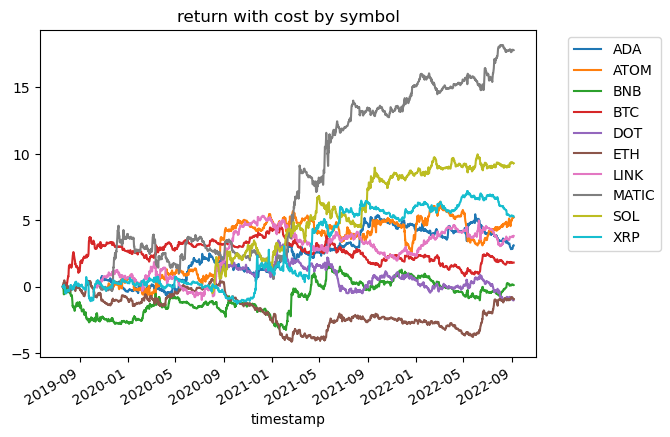

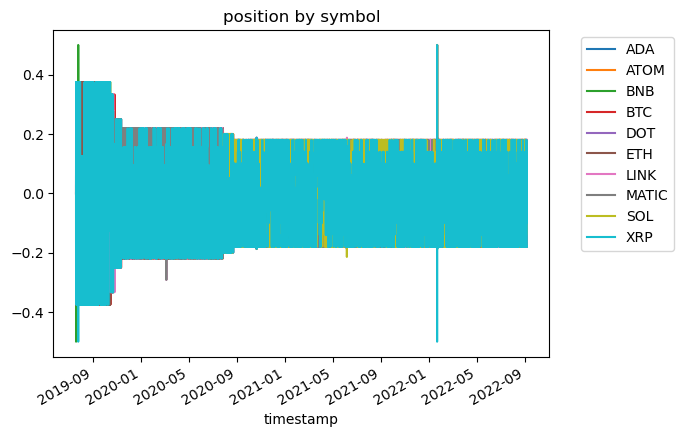

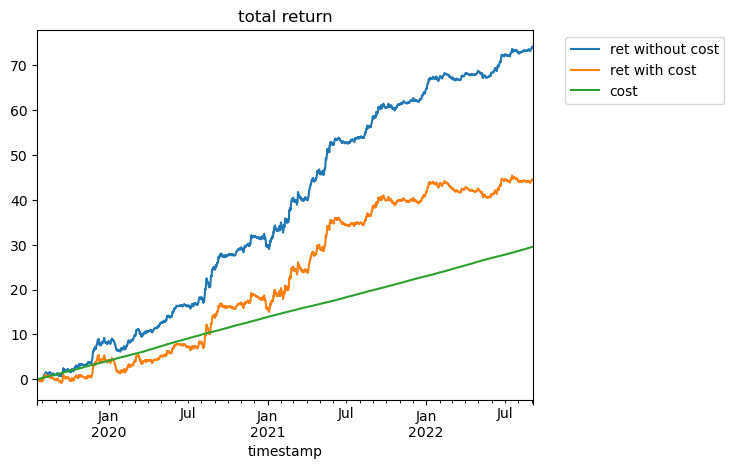

In [3]:
df = pd.read_pickle('/tmp/df_price_type_none.pkl')

model = ExampleModelRank()

# cv
calc_position_cv(model, df)
visualize_result(df.dropna())

# fit and save model as portable format
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/20220908_ranker.xz', 'wb') as f:
    f.write(data)

timestamp                  symbol
2022-08-30 11:00:00+00:00  ADA       0.00
                           ATOM      0.00
                           BNB       0.00
                           BTC       0.00
                           DOT       0.00
                                     ... 
2022-09-06 11:00:00+00:00  ETH       0.18
                           LINK     -0.10
                           MATIC     0.02
                           SOL       0.14
                           XRP       0.10
Name: position, Length: 1690, dtype: float64
['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'SOL', 'XRP']
test shift predict


position1  position2  position3
timestamp                 symbol                                 
2022-08-30 12:00:00+00:00 ADA     -0.055556  -0.055556       0.00
                          ATOM     0.500000   0.500000       0.00
                          BNB     -0.055556  -0.055556       0.00
                          BTC     -0.055556  -0.055556       0.00
                          DOT     -0.055556  -0.055556       0.00
...                                     ...        ...        ...
2022-09-06 10:00:00+00:00 ETH      0.180000   0.180000       0.18
                          LINK    -0.100000  -0.100000      -0.10
                          MATIC    0.020000   0.020000       0.02
                          SOL      0.140000   0.140000       0.14
                          XRP      0.100000   0.100000       0.10

[1670 rows x 3 columns]

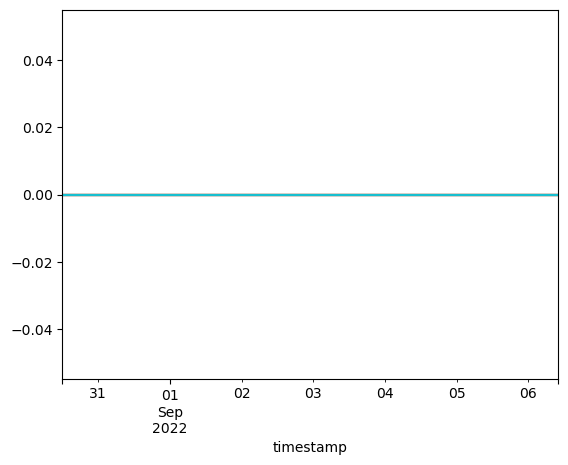

ADA (167, 4)
ATOM (167, 4)
BNB (167, 4)
BTC (167, 4)
DOT (167, 4)
ETH (167, 4)
LINK (167, 4)
MATIC (167, 4)
SOL (167, 4)
XRP (167, 4)


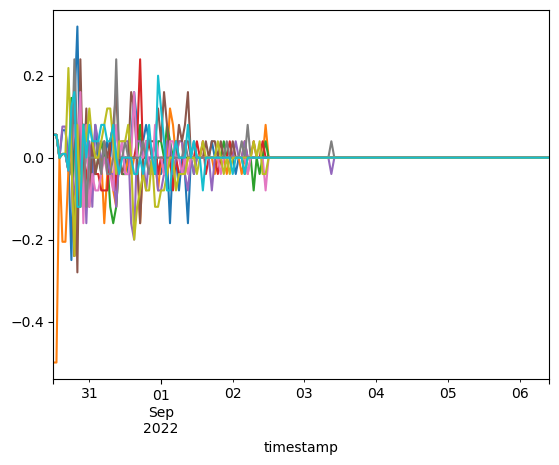

ADA (169, 3)
ATOM (169, 3)
BNB (169, 3)
BTC (169, 3)
DOT (169, 3)
ETH (169, 3)
LINK (169, 3)
MATIC (169, 3)
SOL (169, 3)
XRP (169, 3)


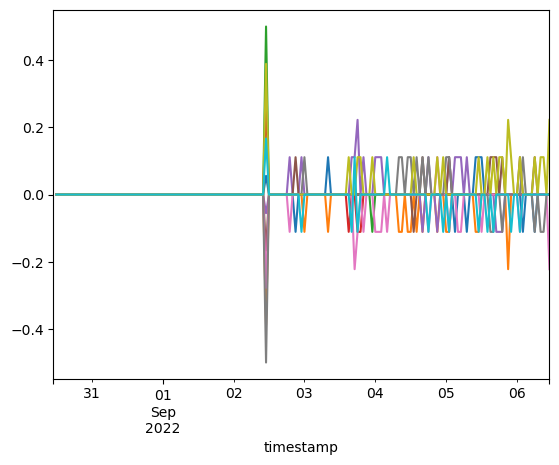

In [4]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/20220908_ranker.xz')
df = pd.read_pickle('/tmp/df_price_type_none.pkl')
df = df[['op', 'hi', 'lo', 'cl', 'volume']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

def _calc_features(df):        
    df = df.copy()

    for i in [2, 4, 8, 24, 48, 72]:
        df['feature_momentum_{}'.format(i)] = (df['cl'] / df.groupby('symbol')['cl'].shift(i) - 1).fillna(0)
    for i in [2, 4, 8, 24, 48, 72]:
        df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: talib.RSI(x, timeperiod=i).fillna(50))

    for col in get_feature_columns(df):
        df[col] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5

    return df

df_features1 = _calc_features(df)
df_features3 = _calc_features(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()

df_test2 = pd.concat([
    df_features1['feature_rsi_72'].rename('feature1'),
    df_features3['feature_rsi_72'].rename('feature3'),
    # df_features1['feature_momentum_72'].rename('feature1'),
    # df_features3['feature_momentum_72'].rename('feature3'),
], axis=1)

for symbol, df_symbol in df_test2.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['feature3'] - df_symbol['feature1']).plot()
plt.show()